## In this notebook I will implement Baysian learning and perform the following:
1. Understand Conditional Independence concept 
1. Implement density estimation using MLE
1. Implement a Naive Bayes Classifier based on Uni-Normal distribution
1. Implement a Full Bayes Classifier based on Multi-Normal distribution
1. Implement a Discrete Naive Bayes Classifier

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Conditional independence  
Define 3 random variables (RV) $X, Y, C$ s.t.:  
1. $X, Y$ and $C$ are all binary
2. The following conditions hold:  
    * P(X=0) = 0.3
    * P(Y=0) = 0.3
    * P(C=0) = 0.5
3. $X$ and $Y$ are not independent
4. $X$ and $Y$ are conditionaly independent given $C$ $(X \perp\!\!\!\perp Y |C)$

In order to define those RV you need to fill the distributions (represent as python dictionaries) below
and then write a function that prove that conditions 3 (`is_X_Y_depndendent`) and 4 (`is_X_Y_given_C_independent`) holds.

Rcall that:   
1. $P(X|Y) = \frac{P(X, Y)}{P(Y)}$  
2. $P(X, Y|C) = \frac{P(X, Y, C)}{P(C)}$
3. $(X \perp\!\!\!\perp Y |C)$   iff  
$\forall x, y,c$: $p(X=x,Y=y|C=c)=p(X=x|C=c)p(Y=y|C=c)$  

Make sure that all the probabilities are valid! 

In [33]:
X = {0: 0.3, 1: 0.7}  # P(X=x)
Y = {0: 0.3, 1: 0.7}  # P(Y=y)
C = {0: 0.5, 1: 0.5}  # P(C=c)

X_Y = {
    (0, 0): 0.1,
    (0, 1): 0.2,
    (1, 0): 0.2,
    (1, 1): 0.5
}  # P(X=x, Y=y)

X_C = {
    (0, 0): 0.2,
    (0, 1): 0.2,
    (1, 0): 0.3,
    (1, 1): 0.3
}  # P(X=x, C=y)

Y_C = {
    (0, 0): 0.2,
    (0, 1): 0.2,
    (1, 0): 0.3,
    (1, 1): 0.3
}  # P(Y=y, C=c)

X_Y_C = {
    (0, 0, 0): 0.08,
    (0, 0, 1): 0.08,
    (0, 1, 0): 0.12,
    (0, 1, 1): 0.12,
    (1, 0, 0): 0.12,
    (1, 0, 1): 0.12,
    (1, 1, 0): 0.18,
    (1, 1, 1): 0.18,
}  # P(X=x, Y=y, C=c)

In [34]:
# You may assume that X, Y and C have the same support (e.g. they are defined on the same space)
# Note: since python suffer from numerical instability you may want to use np.isclose instead of the `==` operator
def is_X_Y_dependent(X, Y, X_Y):
    """
    return True iff X and Y are dependent
    """
    for x in X.keys():
        for y in Y.keys():
            if not np.isclose(X_Y.get((x,y)), X.get(x)*Y.get(y)):
                return True
    return False

def is_X_Y_given_C_independent(X, Y, C, X_C, Y_C, X_Y_C):
    """
    return True iff X_given_C and Y_given_C are independent
    """
    for x in X.keys():
        for y in Y.keys():
            for c in C.keys():
                if not np.isclose((X_Y_C.get((x,y,c))/C.get(c)),(X_C.get((x,c))/C.get(c))*(Y_C.get((y,c))/C.get(c))):
                    return False
    return True

In [35]:
print("X and Y are dependent: {}".format(is_X_Y_dependent(X, Y, X_Y)))
print("X and Y are independent given C: {}".format(is_X_Y_given_C_independent(X, Y, C, X_C, Y_C, X_Y_C)))

X and Y are dependent: True
X and Y are independent given C: True


# Maximum Likelihood estimation  

In probability theory and statistics, the Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant mean rate and independently of the time since the last event.  
The paramter of this distribution is the rate of events in that given time interval, annotated $\lambda$  
if $X$~$Pois(\lambda)$  
then $p(X=k|\lambda) = \frac{\lambda^ke^{-\lambda}}{k!}$  
Where $X$ is a RV $\lambda$ is the rate and $p$ is the pmf

Implement the function `poisson_log_pmf`

In [36]:
def poisson_log_pmf(k, rate):
    """
    k: A discrete instance
    rate: poisson rate parameter (lambda)
    return the log pmf value for instance k given the rate
    """
    p_k = ((rate**k)*np.exp(-rate))/np.math.factorial(k)
    return np.log(p_k)

In the file poisson_1000_samples.csv there are 1000 points drawn from some poisson distribution with a fixed paramter $\lambda$  

In the following section you are going to find a rate that maximizes the likelihood function. You will do this in 2 diffrent ways:
1. Iterative (`possion_iterative_mle`): given a list of possible rates (`rates`), calculate the log likelihood value for each rate and return the rate that has the maximum value
2. Analytic (`possion_analytic_mle`): read the following blog: https://www.statology.org/mle-poisson-distribution/. This blog demonstrate how to derive the MLE of a poisson distribution. Understande the process and implement the function.


In [37]:
poisson_samples = pd.read_csv('data/poisson_1000_samples.csv').values.flatten()
rates = np.linspace(1e-20, 20, num=1000)

In [38]:
def get_poisson_log_likelihoods(samples, rates):
    """
    samples: set of univariate discrete observations
    rates: an iterable of rates to calculate log-likelihood by.
    return: 1d numpy array, where each value represent that log-likelihood value of rates[i]
    """
    likelihoods = []
    n=len(samples)
    likely=0
    for rate in rates:
        sig1= sum([np.log(np.math.factorial(x)) for x in samples])
        sig2= sum(samples)
        likely = -n*rate-sig1+np.log(rate)*sig2
        likelihoods.append(likely)
    return likelihoods

def possion_iterative_mle(samples, rates):
    """
    samples: set of univariate discrete observations
    rate: a rate to calculate log-likelihood by.
    return: the rate that maximizes the likelihood 
    """
    rate = 0.
    likelihoods = get_poisson_log_likelihoods(samples, rates)
    max_likelihood = max(likelihoods)
    max_index = likelihoods.index(max_likelihood)
    return rates[max_index]

def possion_analytic_mle(samples):
    """
    samples: set of univariate discrete observations
    return: the rate that maximizes the likelihood
    """
    n=len(samples)
    rate = (1/n)*sum(samples)
    return rate

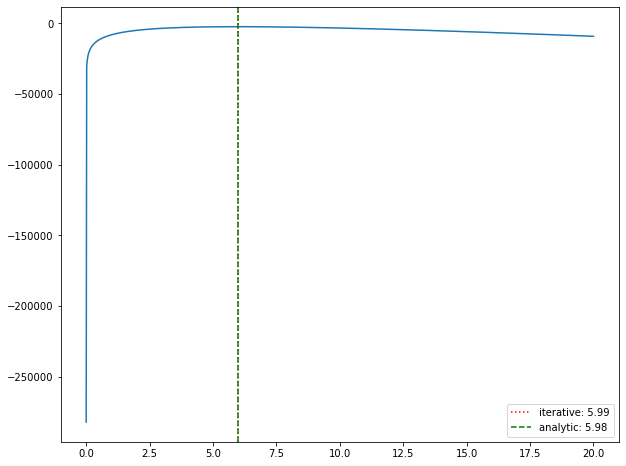

In [39]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)     # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

x = rates
y = get_poisson_log_likelihoods(poisson_samples, rates)

iterative_rate = possion_iterative_mle(poisson_samples, rates)
analytic_rate = possion_analytic_mle(poisson_samples)

plt.plot(x, y)
plt.axvline(x=iterative_rate, linestyle=':', c='r', label=f"iterative: {iterative_rate:.2f}")
plt.axvline(x=analytic_rate, linestyle='--', c='g', label=f"analytic: {analytic_rate:.2f}")
plt.legend()
plt.show()


# Normal Naive Bayes Classifier Vs Normal Full Bayes Classifier
In the following section we are going to compare 2 models on a given dataset. <br>
The 2 classifiers we are going to test are:
1. Naive Bayes classifer.<br>
1. Full Bayes classifier.<br>
Recall that a Naive Bayes classifier makes the following assumption :<br> 
## $$ p(x_1, x_2, ..., x_n|A_j) = \Pi p(x_i | A_j) $$
But the full Bayes classifier will not make this assumption.<br>

### The Data Story

In a faraway land called **Randomistan** there is a rare animal called the **Randomammal**.<br> 
We have gathered data about this unique animal to help the **randomian** researchers in observing this beast. <br>
For a 1000 days straight we have measured the temperature and the humidity in Randomistan and whether the Randomammal was spotted or not. <br>
The well known randomian **Bob** is a bit of a lazy researcher so he likes to keep things simple, and so he assumes that the temperature and the humidity are independent given the class. <br>
**Alice** on the other hand is a hard working researcher and does not make any assumptions, she's young and is trying to gain some fame in the randomian community.

The dataset contains 2 features (**Temperature**, **Humidity**) alongside a binary label (**Spotted**) for each instance.<br>

We are going to test 2 different classifiers :
* Naive Bayes Classifier (Bob)
* Full Bayes Classifier. (Alice)

Both of our researchers assume that our features are normally distributed. But while Bob with his Naive classifier will assume that the features are independent, Alice and her Full Bayes classifier will not make this assumption.<br><br>
Let's start off by loading the data (train, test) into a pandas dataframe and then converting them
into numpy arrays.<br>
The datafiles are :
- randomammal_train.csv
- randomammal_test.csv

In [40]:
# Load the train and test set into a pandas dataframe and convert them into a numpy array.
# The columns order: ['Temp', 'Humidity', 'Spotted']
train_set = pd.read_csv('data/randomammal_train.csv').values
test_set = pd.read_csv('data/randomammal_test.csv').values

# Data Visualization
Draw a scatter plot of the training data where __x__=Temerature and **y**=Humidity. <br>
Use color to distinguish points from different classes.<br>
Stop for a minute to think about Alice and Bob's approaches and which one you expect to work better.

<function matplotlib.pyplot.show(close=None, block=None)>

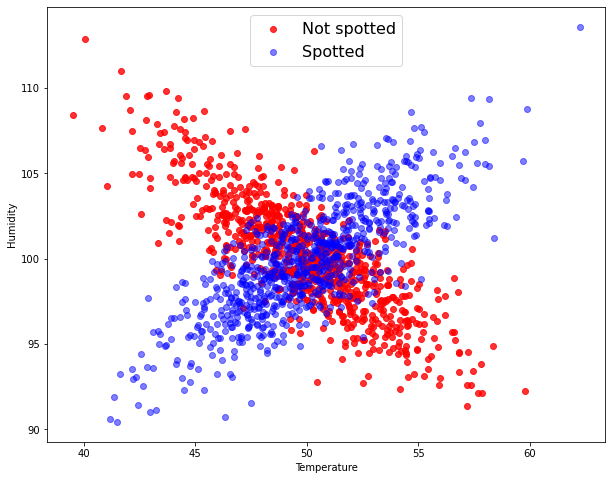

In [41]:
x_spotted=train_set[(train_set[:,-1]==1)][:,0]
x_not_spotted=train_set[(train_set[:,-1]==0)][:,0]
y_spotted=train_set[(train_set[:,-1]==1)][:,1]
y_not_spotted=train_set[(train_set[:,-1]==0)][:,1]

plt.scatter(x_not_spotted, y_not_spotted, c ="red", label="Not spotted",alpha=0.8)
plt.scatter(x_spotted, y_spotted, c ="blue", label="Spotted", alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.legend(fontsize="16")
plt.show

## Bob's Naive Model

Start with implementing the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) probability density function in the next cell: 
$$ \frac{1}{\sqrt{2\pi \sigma^2}} \cdot e ^{-\frac{(x - \mu)^2}{2\sigma^2}} $$
Where :
* $\mu$ is the distribution mean.
* $\sigma$ is the distribution standard deviation.

In [42]:
def normal_pdf(x, mean, std):
    """
    Calculate normal desnity function for a given x, mean and standrad deviation.
    Input:
    - x: A value we want to compute the distribution for.
    - mean: The mean value of the distribution.
    - std:  The standard deviation of the distribution.
    Returns the normal distribution pdf according to the given mean and std for the given x.    
    """
    coefficient = 1/ (2*np.pi*std**2)**0.5
    return coefficient * np.exp(-(x-mean)**2/(2*std**2))    

Implement the **NaiveNormalClassDistribution** in the next cell and build a distribution object for each class.
Recall that when using the naive assumption, we assume our features are indepenent given the class. Meaning:
$$ P(x_1, x_2 | Y) = p(x_1 | Y) \cdot p(x_2 | Y)$$


Since we assume our features are normally distributed we need to find the mean and std for each feature in order for us to compute those probabilites. 

In [43]:
class NaiveNormalClassDistribution():
    def __init__(self, dataset, class_value):
        """
        A class which encapsulates the relevant parameters(mean, std) for a class conditinoal normal distribution.
        The mean and std are computed from a given data set.
        Input
        - dataset: The dataset as a 2d numpy array, assuming the class label is the last column
        - class_value : The class to calculate the parameters for.
        """
        self.dataset = dataset
        self.class_value = class_value
        self.class_instances = self.dataset[self.dataset[:,-1] == self.class_value].shape[0]
        x_t = np.array([dataset[(dataset[:,-1] == class_value)][:,0]])
        x_h = np.array([dataset[(dataset[:,-1] == class_value)][:,1]])
        self.mean_t = np.mean(x_t)
        self.std_t = np.std(x_t)
        self.mean_h =  np.mean(x_h)
        self.std_h = np.std(x_h-self.mean_h)
    
    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        p_class = self.class_instances/self.dataset.shape[0]
        return p_class
    
    def get_instance_likelihood(self, x):
        """
        Returns the likelihood porbability of the instance under the class according to the dataset distribution.
        """
        likelihood_t = normal_pdf(x[0], self.mean_t, self.std_t) 
        likelihood_h = normal_pdf(x[1], self.mean_h, self.std_h)
        return likelihood_t*likelihood_h
    
    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        posterior = self.get_instance_likelihood(x)*self.get_prior()
        return posterior

In [44]:
# Build NaiveNormalClassDistribution for each class
naive_normal_CD_0 = NaiveNormalClassDistribution(train_set, 0)
naive_normal_CD_1 = NaiveNormalClassDistribution(train_set, 1)

Implement the **MAPClassifier** class and build a MAPClassifier object containing the 2 distribution objects you just made above.

In [45]:
class MAPClassifier():
    def __init__(self, ccd0 , ccd1):
        """
        A Maximum a posteriori classifier. 
        This class will hold 2 class distributions, one for class 0 and one for class 1, and will predict an instance
        by the class that outputs the highest posterior probability for the given instance.
        Input
            - ccd0 : An object contating the relevant parameters and methods for the distribution of class 0.
            - ccd1 : An object contating the relevant parameters and methods for the distribution of class 1.
        """
        self.ccd0 = ccd0
        self.ccd1 = ccd1
    
    def predict(self, x):
        """
        Predicts the instance class using the 2 distribution objects given in the object constructor.
        Input
            - An instance to predict.
        Output
            - 0 if the posterior probability of class 0 is higher and 1 otherwise.
        """
        if self.ccd0.get_instance_posterior(x)>self.ccd1.get_instance_posterior(x):
            return 0
        else:
            return 1

In [46]:
naive_normal_classifier = MAPClassifier(naive_normal_CD_0, naive_normal_CD_1)

### Evaluate model
Implement the **compute_accuracy** function in the next cell. Use it and the 2 distribution objects you created to compute the accuracy on the test set.

In [47]:
def compute_accuracy(testset, map_classifier):
    """
    Compute the accuracy of a given a testset using a MAP classifier object.
    Input
        - testset: The testset for which to compute the accuracy (Numpy array). where the class label is the last column
        - map_classifier : A MAPClassifier object capable of prediciting the class for each instance in the testset.
    Ouput
        - Accuracy = #Correctly Classified / #testset size
    """
    correct = 0
    for instance in testset:
        if map_classifier.predict(instance)==instance[-1]:
            correct+=1
    return correct/testset.shape[0]

In [48]:
# Compute the naive model accuracy and store it in the naive accuracy variable.
naive_accuracy = compute_accuracy(test_set, naive_normal_classifier)
print("Naive bayes accuracy: {}".format(naive_accuracy))

Naive bayes accuracy: 0.495


## Alice's Full Model

Start with Implementing the [multivariate normal](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) distribution probability density function in the next cell.

## $$ (2\pi)^{-\frac{d}{2}} det(\Sigma )^{-\frac{1}{2}} \cdot e ^{-\frac{1}{2}(x-\mu)^T \Sigma ^ {-1} (x - \mu) }$$

Where : 
* $\mu$ is the distribution mean vector. (length 2 in our case)
* $\Sigma$ Is the distribution covarince matrix. (size 2x2 in our case)

In [49]:
def multi_normal_pdf(x, mean, cov):
    """
    Calculate multi variable normal desnity function for a given x, mean and covarince matrix.
    Input:
    - x: A value we want to compute the distribution for.
    - mean: The mean vector of the distribution.
    - cov:  The covariance matrix of the distribution.
    Returns the normal distribution pdf according to the given mean and var for the given x.    
    """
    det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    delta_x_mean = (x-mean).reshape(2,1) 
    delta_x_mean_T = delta_x_mean.reshape(1,2)
    d = len(x)
    multi_pdf = (2*np.pi)**(-(d/2)) * (det ** (-0.5)) * np.exp(-0.5 * delta_x_mean_T @ cov_inv @ (delta_x_mean))
    return multi_pdf

Implement the **MultiNormalClassDistribution** and build a distribution object for each class.

In the full bayes model we will not make any simplyfing assumptions, meaning, we will use a multivariate normal distribution. <br>
And so, we'll need to compute the mean of each feature and to compute the covariance between the features to build the covariance matrix.


In [50]:
class MultiNormalClassDistribution():
    def __init__(self, dataset, class_value):
        """
        A class which encapsulate the relevant parameters(mean, cov matrix) for a class conditinoal multi normal distribution.
        The mean and cov matrix (You can use np.cov for this!) will be computed from a given data set.
        Input
        - dataset: The dataset as a numpy array
        - class_value : The class to calculate the parameters for.
        """
        self.dataset = dataset
        self.class_value = class_value
        self.data_per_class = self.dataset[self.dataset[:,-1] == self.class_value]
        self.mean = np.mean(self.data_per_class[:,:-1], axis = 0)
        self.std = np.std(self.data_per_class[:,:-1], axis = 0)
        self.cov = np.cov(self.data_per_class[:,:-1].T)
        
    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        num_of_class_value = self.dataset[self.dataset[:,2] == self.class_value].shape[0] 
        prior = num_of_class_value / self.dataset.shape[0]
        return prior
    
    def get_instance_likelihood(self, x):
        """
        Returns the likelihood of the instance under the class according to the dataset distribution.
        """
        return multi_normal_pdf(x[:-1], self.mean, self.cov)
    
    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        posterior = self.get_instance_likelihood(x) * self.get_prior() 
        return posterior

In [51]:
# Build the a MultiNormalClassDistribution for each class.
multi_normal_CD_0 = MultiNormalClassDistribution(train_set, 0)
multi_normal_CD_1 = MultiNormalClassDistribution(train_set, 1)

build a MAPClassifier object contating the 2 distribution objects you just made above.

In [52]:
multi_normal_classifier = MAPClassifier(multi_normal_CD_0, multi_normal_CD_1)

### Evaluate model
Use the **compute_accuracy** function and the 2 distribution objects you created to compute the accuracy on the test set.

In [53]:
# Compute the naive model accuracy and store it in the naive accuracy variable.
full_accuracy = compute_accuracy(test_set, multi_normal_classifier)
print("Full bayes accuracy: {}".format(full_accuracy))

Full bayes accuracy: 0.7975


## Results

Use a plot bar to showcase the models accuracy.

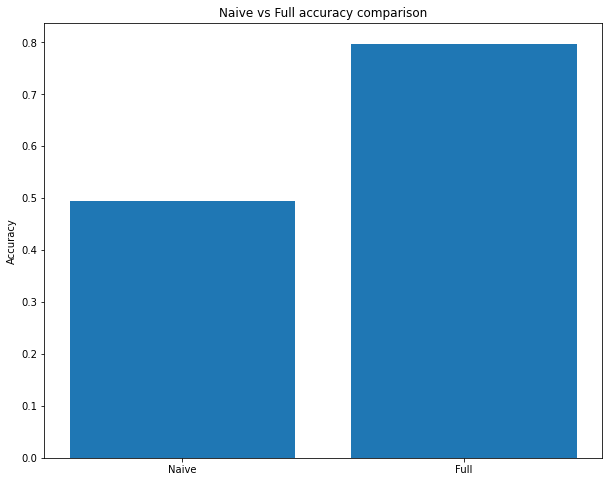

In [54]:
# Bar plot of accuracy of each model side by side.
plt.bar(x=['Naive', 'Full'], height=[naive_accuracy, full_accuracy])
plt.title("Naive vs Full accuracy comparison")
plt.ylabel("Accuracy")
plt.show() #should add this to remove print of text line

# Comparing Max a posteriori, prior, and likelihood results

For each of the classifiers above (naive Bayes and full Bayes, in which we compare posterior probabilities), we explore how classifiers would perform if we compare (1) only prior probabilities or (2) only likelihoods. 

In this section, you will implement MaxPrior and MaxLikelihood classifiers similarly to MAPClassifier, and then visualize the performance of the three models (MAP, MaxPrior, and MaxLikelihood) for each of the examples of above (naive Bayes and full Bayes).

For example, your visualization can be a graph where accuracy is the y-axis, "MaxPrior", "MaxLikelihood", and "MAP" are the x-axis values, and at each x-value, there will be two bars - one for the naive Bayes, and one for the full Bayes.  

Other graphs (that make sense / are intuitive) will be accepted as well.

Implement the **MaxPrior** class and build a MaxPrior object like you did above with the **MAPClassifier**.

In [55]:
class MaxPrior():
    def __init__(self, ccd0 , ccd1):
        """
        A Maximum prior classifier. 
        This class will hold 2 class distributions, one for class 0 and one for class 1, and will predicit an instance
        by the class that outputs the highest prior probability for the given instance.
        Input
            - ccd0 : An object contating the relevant parameters and methods for the distribution of class 0.
            - ccd1 : An object contating the relevant parameters and methods for the distribution of class 1.
        """
        self.ccd0 = ccd0
        self.ccd1 = ccd1
    
    def predict(self, x):
        """
        Predicts the instance class using the 2 distribution objects given in the object constructor.
        Input
            - An instance to predict.
        Output
            - 0 if the posterior probability of class 0 is higher and 1 otherwise.
        """
        if self.ccd0.get_prior() > self.ccd1.get_prior():
            return 0
        else:
            return 1

Implement the **MaxLikelihood** class and build a MaxLikelihood object like you did above with the **MAPClassifier**.

In [56]:
class MaxLikelihood():
    def __init__(self, ccd0 , ccd1):
        """
        A Maximum Likelihood classifier. 
        This class will hold 2 class distributions, one for class 0 and one for class 1, and will predicit an instance
        by the class that outputs the highest likelihood probability for the given instance.
    
        Input
            - ccd0 : An object contating the relevant parameters and methods for the distribution of class 0.
            - ccd1 : An object contating the relevant parameters and methods for the distribution of class 1.
        """
        self.ccd0 = ccd0
        self.ccd1 = ccd1
    
    def predict(self, x):
        """
        Predicts the instance class using the 2 distribution objects given in the object constructor.
    
        Input
            - An instance to predict.
        Output
            - 0 if the posterior probability of class 0 is higher and 1 otherwise.
        """
        if self.ccd0.get_instance_likelihood(x) > self.ccd1.get_instance_likelihood(x):
            return 0
        else:
            return 1

### Run and evaluate the models

Repeat the process you did for the MAPClassifier, now for the MaxPrior and MaxLikelihood classifiers:
1. Feed the naive_normal distributions and the multi_normal distributions you made for each class into the new models you made in this section
2. Evaluate the accuracies
3. Plot the results as described in the beginning of this section

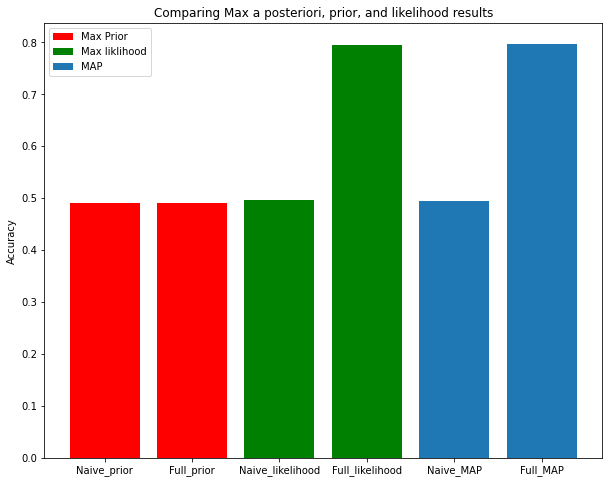

In [57]:
naive_MaxPrior_Classifier = MaxPrior(naive_normal_CD_0, naive_normal_CD_1)
multi_MaxPrior_Classifier = MaxPrior(multi_normal_CD_0, multi_normal_CD_1)

naive_MaxLiklihood_Classifier = MaxLikelihood(naive_normal_CD_0, naive_normal_CD_1)
multi_MaxLiklihood_Classifier = MaxLikelihood(multi_normal_CD_0, multi_normal_CD_1)

naive_accuracy_MaxPrior = compute_accuracy(test_set, naive_MaxPrior_Classifier)
naive_accuracy_MaxLiklihood = compute_accuracy(test_set, naive_MaxLiklihood_Classifier)

full_accuracy_MaxPrior = compute_accuracy(test_set, multi_MaxPrior_Classifier)
full_accuracy_MaxLiklihood = compute_accuracy(test_set, multi_MaxLiklihood_Classifier)

plt.bar(x=['Naive_prior', 'Full_prior'], height=[naive_accuracy_MaxPrior, full_accuracy_MaxPrior], color = 'red', label = 'Max Prior')
plt.bar(x=['Naive_likelihood', 'Full_likelihood'], height=[naive_accuracy_MaxLiklihood, full_accuracy_MaxLiklihood], color = 'green', label = 'Max liklihood')
plt.bar(x=['Naive_MAP', 'Full_MAP'], height=[naive_accuracy, full_accuracy], label = 'MAP')
plt.title("Comparing Max a posteriori, prior, and likelihood results")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Discrete Naive Bayes Classifier 

We will now build a discrete naive Bayes based classifier using **Laplace** smoothing.
In the recitation, we saw how to compute the probability for each attribute value under each class:

$$ P(x_j | A_i) = \frac{n_{ij} + 1}{n_i + |V_j|} $$
Where:
* $n_{ij}$ The number of training instances with the class $A_i$ and the value $x_j$ in the relevant attribute.
* $n_i$ The number of training instances with the class $A_i$
* $|V_j|$ The number of possible values of the relevant attribute.

In order to compute the likelihood we assume:
$$ P(x| A_i) = \prod\limits_{j=1}^{n}P(x_j|A_i) $$

And to classify an instance we will choose : 
$$\arg\!\max\limits_{i} P(A_i) \cdot P(x | A_i)$$


## Data
We will try to predict breast cancer again only this time from a different dataset, 
<br> you can read about the dataset here : [Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer)<br>
Load the training set and test set provided for you in the data folder.
 - breast_trainset.csv
 - breast_testset.csv
 

In [58]:
# Load the train and test set into a pandas dataframe and convert them into a numpy array.
train_set = pd.read_csv('data/breast_trainset.csv').values
test_set = pd.read_csv('data/breast_testset.csv').values

## Build A Discrete Naive Bayes Distribution for each class
Implement the **DiscreteNBClassDistribution** in the next cell and build a distribution object for each class.

In [59]:
EPSILON = 1e-6 # if a certain value only occurs in the test set, the probability for that value will be EPSILLON.

class DiscreteNBClassDistribution():
    def __init__(self, dataset, class_value):
        """
        A class which computes and encapsulate the relevant probabilites for a discrete naive bayes 
        distribution for a specific class. The probabilites are computed with laplace smoothing.
        
        Input
        - dataset: The dataset as a numpy array.
        - class_value: Compute the relevant parameters only for instances from the given class.
        """
        self.dataset = dataset
        self.class_value = class_value
        self.data_per_class = self.dataset[self.dataset[:,-1] == self.class_value]
        self.instances = self.data_per_class.shape[0]
    
    def get_prior(self):
        """
        Returns the prior porbability of the class according to the dataset distribution.
        """
        prior = self.instances / self.dataset.shape[0]
        return prior
    
    def get_instance_likelihood(self, x):
        """
        Returns the likelihood of the instance under the class according to the dataset distribution.
        """
        likelihood = 1
        for feature in range(self.data_per_class.shape[1]-1):
            possible_values = np.unique(self.data_per_class[:,feature]).shape[0]
            count_values = self.data_per_class[self.data_per_class[:,feature] == x[feature]].shape[0]
            if (count_values==0): #This means we encountered a value that hasn't been viewed in the train_set
                p = EPSILON
            else:
                p = (count_values+1) / (self.instances + possible_values)
            likelihood = likelihood*p
        return likelihood
    
    def get_instance_posterior(self, x):
        """
        Returns the posterior porbability of the instance under the class according to the dataset distribution.
        * Ignoring p(x)
        """
        postirior = self.get_instance_likelihood(x) * self.get_prior()
        return postirior

In [60]:
discrete_naive_CD_0 = DiscreteNBClassDistribution(train_set, 0)
discrete_naive_CD_1 = DiscreteNBClassDistribution(train_set, 1)

build a MAPClassifier object contating the 2 distribution objects you just made above.

In [61]:
discrete_naive_classifier = MAPClassifier(discrete_naive_CD_0, discrete_naive_CD_1)

Use the **compute_accuracy** function and the 2 distribution objects you created to compute the accuracy on the test set.

In [62]:
accuracy = compute_accuracy(test_set, discrete_naive_classifier)
print("Discrete Naive Bayes accuracy: {}".format(accuracy))

Discrete Naive Bayes accuracy: 0.7368421052631579
